### College of Computing and Informatics, Drexel University
### INFO 323: Cloud Computing and Big Data, Spring 2020
### Due: Sunday, June 14, 2020
---

## Final Project Report

## Project Title: Predicting Breast Cancer Using Apache Spark

## Student(s): Rachel Fisher, Eugene Yakovlev

#### Date: 6/13/2020
---

# Project Requirements

This final project examines the level of knowledge the students have learned from the course. The project must be done on a cloud computing platform, for example, the Apache Spark platform.

#### Abstract
---
*(Briefly summarize the cloud-based project including the problem, data sets, models, evaluation, and final findings.)* 

### 1. Introduction
---
*(Introduce the project, describe the objectives, and present the results. This section will provide an overview of the entire project including the description of the data sets and the cloud-based data analytics methods and techniques the team used for analyzing the data to address the problem. Highlight the key findings.)* 

In [3]:
# 

### 2. Problem Definition
---
*(Define the problem that will be solved in this cloud computing project.)*

Worldwide, breast cancer is the most common type of cancer in women and the second highest in terms of mortality rates. Detecting and diagnosing cancer early can help decrease mortality rates. Diagnosis of breast cancer is performed when an abnormal lump is found, and a doctor will determine whether it is cancerous or not, and if it is, whether is has spread to other parts of the body.

In this dataset, we're given information on the lump as well as whether that patient was diagnosed with breast cancer or not. We want to split this dataset into training and test datasets to see if we can use the information on the lumps to predict whether that patient was diagnosed with breast cancer or not.

If our model is accurate, then it could be used by doctors who have a patient with a lump/tumor in their breast. The doctor could input the values used in our dataset, describing the size and appearance of the lump, and get a value indicating if the lump is cancerous or not.

### 3. Data
---
*(Describe the origin, format, and  charateristics of the data.)*

We collected the breast cancer prediction dataset from Kaggle (https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset) which was provided by Merishna Singh Suwal. The dataset orginated from Dr. William H. Wolberg from the University of Wisconsin Hospitals, Madison.

In [4]:
data = spark.read.option("inferSchema", "true").option("header", "true").csv("Breast_cancer_data.csv")
data.createOrReplaceTempView("data_view")

The dataset is a CSV file and contains 6 columns; 5 columns will be used as predictors:

mean_radius: mean distance from the center to points on the perimeter

mean_texture: standard deviation of gray-scale values

mean_perimeter: mean size of the core tumor

mean_area: mean area of the core tumor

mean_smoothness: mean of the local variation in radius lengths


And 1 column will be used as our label:

diagnosis: the diagnosis of the breast dissues (1 = cancerous, 0 = benign)

In [5]:
data.columns

['mean_radius',
 'mean_texture',
 'mean_perimeter',
 'mean_area',
 'mean_smoothness',
 'diagnosis']

The 5 predictors are doubles (having decimals) and the diagnosis is a binary integer (0 or 1).

In [6]:
data.printSchema()

root
 |-- mean_radius: double (nullable = true)
 |-- mean_texture: double (nullable = true)
 |-- mean_perimeter: double (nullable = true)
 |-- mean_area: double (nullable = true)
 |-- mean_smoothness: double (nullable = true)
 |-- diagnosis: integer (nullable = true)



There are 569 rows of data before cleaning. Each row represents one case/patient. Based on the mean of the diagnosis column, we can see that more cases in the dataset had 1 values, meaning more cases are positive for breast cancer in this dataset.

In [7]:
data.describe().toPandas()

summary         mean_radius       mean_texture     mean_perimeter  \
0   count                 569                569                569   
1    mean  14.127291739894563  19.28964850615117  91.96903339191566   
2  stddev  3.5240488262120793  4.301035768166948   24.2989810387549   
3     min               6.981               9.71              43.79   
4     max               28.11              39.28              188.5   

           mean_area       mean_smoothness           diagnosis  
0                569                   569                 569  
1  654.8891036906857     0.096360281195079  0.6274165202108963  
2  351.9141291816529  0.014064128137673616  0.4839179564031685  
3              143.5               0.05263                   0  
4             2501.0                0.1634                   1

### 4. Exploratory Data Analysis
---
*(Cleanse, wrangle, transform, and analyze the data. Compute descriptive statistics and visualize the values of features and correlations between different features. Explain the process and the results.)*

First we wanted to remove any rows that had any null values

In [8]:
data = data.na.drop("any")

In [9]:
data.describe().toPandas()

summary         mean_radius       mean_texture     mean_perimeter  \
0   count                 569                569                569   
1    mean  14.127291739894563  19.28964850615117  91.96903339191566   
2  stddev  3.5240488262120793  4.301035768166948   24.2989810387549   
3     min               6.981               9.71              43.79   
4     max               28.11              39.28              188.5   

           mean_area       mean_smoothness           diagnosis  
0                569                   569                 569  
1  654.8891036906857     0.096360281195079  0.6274165202108963  
2  351.9141291816529  0.014064128137673616  0.4839179564031685  
3              143.5               0.05263                   0  
4             2501.0                0.1634                   1

The counts for before and after removing the nulls are the same (569), so we know that there were no null values in the dataset.

We also wanted to check that the diagnosis column only contained the values 0 and 1, as it is a binary indicator of whether the lump was cancerous or not.

In [10]:
spark.sql("""
SELECT DISTINCT DIAGNOSIS
FROM data_view
""").show()

+---------+
|DIAGNOSIS|
+---------+
|        1|
|        0|
+---------+



By checking the distinct values above, we can see that the diagnosis column does only have values of 0 or 1, so this does not need to be cleaned.

Using the describe() function we are able to look at the mean, standard deviation, maximum, and minium values for each column.

In [11]:
data.describe().toPandas()

summary         mean_radius       mean_texture     mean_perimeter  \
0   count                 569                569                569   
1    mean  14.127291739894563  19.28964850615117  91.96903339191566   
2  stddev  3.5240488262120793  4.301035768166948   24.2989810387549   
3     min               6.981               9.71              43.79   
4     max               28.11              39.28              188.5   

           mean_area       mean_smoothness           diagnosis  
0                569                   569                 569  
1  654.8891036906857     0.096360281195079  0.6274165202108963  
2  351.9141291816529  0.014064128137673616  0.4839179564031685  
3              143.5               0.05263                   0  
4             2501.0                0.1634                   1

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Below is the correlation between the pairs of features in the dataset. We converted the dataset into a pandas dataframe in order to compute the correlation.

In the correlation visualization, we can see there is a strong positive correlation between the mean_radius, mean_perimeter, and the mean_area. This makes sense, as all 3 of these featuers signify the size of the lump, so as one increases, the other 2 will as well.

As for the diagnosis, all other features have a negative correlation with the diagnosis. So as the values of the other features increase, the diagnosis value decreases; meaning the diagnosis will get closer to 0, indicating the lump is non-cancerous. The features that have the strongest correlation with the diagnosis is the mean_radius (-0.73), mean_perimeter (-0.74), and the mean_area (-0.71). This actually means that the larger the size of the tumor, the less likely it is to be cancerous, which is surprising, as we thought the opposite would be true.

In [13]:
data_pd = data.toPandas()

In [14]:
corr = data_pd.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Based on the above correlations, we wanted to plot the pairs of features that had the highest correlation.

First is the mean_radius vs mean_perimeter vs mean_area, which we can see all have a strong positive correlation.

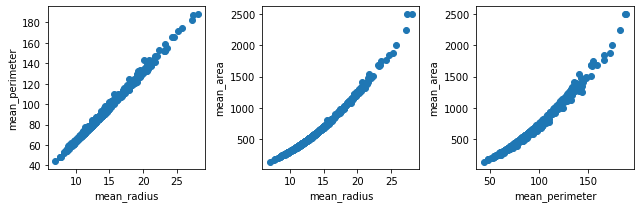

In [15]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.scatter(data_pd['mean_radius'], data_pd['mean_perimeter'])
plt.xlabel('mean_radius')
plt.ylabel('mean_perimeter')
plt.subplot(132)
plt.scatter(data_pd['mean_radius'], data_pd['mean_area'])
plt.xlabel('mean_radius')
plt.ylabel('mean_area')
plt.subplot(133)
plt.scatter(data_pd['mean_perimeter'], data_pd['mean_area'])
plt.xlabel('mean_perimeter')
plt.ylabel('mean_area')
plt.tight_layout()

Next we ploted all of the features vs the diagnosis. We can see that for the mean_radius, mean_perimeter, and the mean_area (which all had the strongest negative correlation with diagnosis), the graph shows that the lower values for that feature are associated with a diagnosis of 1 (meaning cancerous). For the mean_texture and mean_smoothness, we can see that the size of the distribution is greater, indicating a less strong correlation.

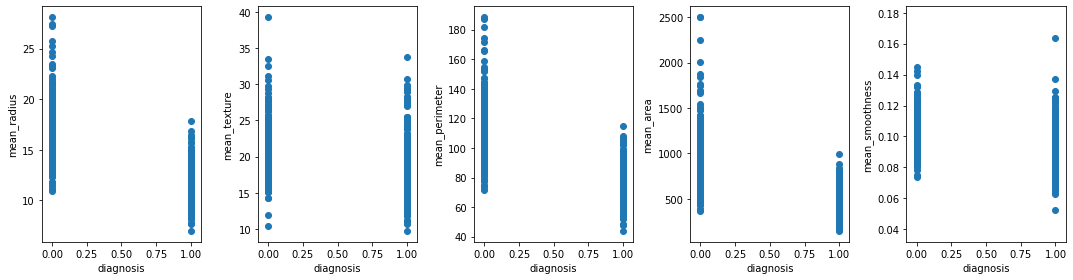

In [16]:
plt.figure(figsize=(15, 4))

plt.subplot(151)
plt.scatter(data_pd['diagnosis'], data_pd['mean_radius'])
plt.xlabel('diagnosis')
plt.ylabel('mean_radius')
plt.subplot(152)
plt.scatter(data_pd['diagnosis'], data_pd['mean_texture'])
plt.xlabel('diagnosis')
plt.ylabel('mean_texture')
plt.subplot(153)
plt.scatter(data_pd['diagnosis'], data_pd['mean_perimeter'])
plt.xlabel('diagnosis')
plt.ylabel('mean_perimeter')
plt.subplot(154)
plt.scatter(data_pd['diagnosis'], data_pd['mean_area'])
plt.xlabel('diagnosis')
plt.ylabel('mean_area')
plt.subplot(155)
plt.scatter(data_pd['diagnosis'], data_pd['mean_smoothness'])
plt.xlabel('diagnosis')
plt.ylabel('mean_smoothness')
plt.tight_layout()

### 5. Modeling and Evaluation
---
*(Build analytic models and evaluate the models on the data. The analytics should be guided by the problem defined earlier. Explain the process and results.)*

To prepare the dataset, we loaded in the .csv file and converted the 'diagnosis' column to a column of doubles, labeled 'label.' The 'label' column is going to be used in future steps as the classifier of each observation in the dataset.

In [18]:
df = spark.read.option("inferSchema", "true").option("header", "true").csv("Breast_cancer_data.csv")
df = df.withColumn("label", df["diagnosis"].cast("double"))
df.show(5)

+-----------+------------+--------------+---------+---------------+---------+-----+
|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|diagnosis|label|
+-----------+------------+--------------+---------+---------------+---------+-----+
|      17.99|       10.38|         122.8|   1001.0|         0.1184|        0|  0.0|
|      20.57|       17.77|         132.9|   1326.0|        0.08474|        0|  0.0|
|      19.69|       21.25|         130.0|   1203.0|         0.1096|        0|  0.0|
|      11.42|       20.38|         77.58|    386.1|         0.1425|        0|  0.0|
|      20.29|       14.34|         135.1|   1297.0|         0.1003|        0|  0.0|
+-----------+------------+--------------+---------+---------------+---------+-----+
only showing top 5 rows



There are 5 columns that represent the features in an observation. There are all doubles. These are the features that are going to be used to predict and compared to the training dataset to make label predictions.

In [19]:
featureColumns = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']

In [20]:
# print num rows in df
print("Number of rows:", df.count())
# print num columns in df
print("Number of columns:", len(df.columns))

Number of rows: 569
Number of columns: 7


# VectorAssembler
To create an aggregate column containing the observation features, we used pyspark's VectorAssembler to specify the feature columns and output the result in a column called 'features'

In [21]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")

In [22]:
df = assembler.transform(df)

The 'features' has been added that contains an array of features in one column.

In [23]:
df.show(5)

+-----------+------------+--------------+---------+---------------+---------+-----+--------------------+
|mean_radius|mean_texture|mean_perimeter|mean_area|mean_smoothness|diagnosis|label|            features|
+-----------+------------+--------------+---------+---------------+---------+-----+--------------------+
|      17.99|       10.38|         122.8|   1001.0|         0.1184|        0|  0.0|[17.99,10.38,122....|
|      20.57|       17.77|         132.9|   1326.0|        0.08474|        0|  0.0|[20.57,17.77,132....|
|      19.69|       21.25|         130.0|   1203.0|         0.1096|        0|  0.0|[19.69,21.25,130....|
|      11.42|       20.38|         77.58|    386.1|         0.1425|        0|  0.0|[11.42,20.38,77.5...|
|      20.29|       14.34|         135.1|   1297.0|         0.1003|        0|  0.0|[20.29,14.34,135....|
+-----------+------------+--------------+---------+---------------+---------+-----+--------------------+
only showing top 5 rows



Next we wanted to split the dataset into a training and test dataset. We split the dataset, 80% to train and 20% to test.

In [24]:
import random

random.seed(12345)
train, test = df.randomSplit([0.8, 0.2])

In [25]:
trainCount = train.count()
testCount = test.count()

print("There are", trainCount, "in the train dataset.")
print("There are", testCount, "in the test dataset.")

There are 450 in the train dataset.
There are 119 in the test dataset.


# DecisionTreeClassifier

Decision trees and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.

With great promises from the model, we wanted to see how well the DecisionTreeClassifier would work with our dataset so it was our first model. The higher the accuracy, the better. We wouldn't want to miss/false identify a cancer patient.

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier

dtModel = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5, minInstancesPerNode=20, impurity="gini")

In [27]:
fittedDt = dtModel.fit(train)

In [28]:
predictions = fittedDt.transform(test)

After the DT model was fitted to the training dataset and then transformed to the test dataset, we had our predictions.

In [29]:
predictions.select("prediction","label").show(10)

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 10 rows



# MulticlassClassificationEvaluator
Used to evaluate accuracy of the model.

In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [31]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

In [32]:
accuracy = evaluator.evaluate(predictions)

In [33]:
accuracy 

0.8988184364654954

Our model was successful in predicting the true diagnosis of a cancer lump observation 89.88% of the time! Now convert DataFrame to RDD for using xxxxMetrics

## Use MulticlassMetrics to get confusion matrix

In [34]:
outRdd = predictions\
  .select("prediction", "label")\
  .rdd.map(lambda x: (float(x[0]), float(x[1])))

In [35]:
metrics = MulticlassMetrics(outRdd)

In [36]:
metrics.confusionMatrix().toArray()

array([[39.,  7.],
       [ 5., 68.]])

- True Positive (TP) - label is positive and prediction is also positive - 39 observation
- True Negative (TN) - label is negative and prediction is also negative - 68 observations
- False Positive (FP) - label is negative but prediction is positive - 5 observations
- False Negative (FN) - label is positive but prediction is negative - 7 observations

Total - 119 observations in the train dataset

Another way to interpret this is that there are 7 cases that have been diagnosed with cancer that were predicted to not have cancer by the model. This is the most extreme, and worst case (life threathening). This is called a false-negative, or a Type II error.

On the other hand, there are 5 cases that do not have cancer, but have been predicted to have cancer. This isn't as terrible because the patients will undergo more testing and discover they don't have cancer later - but still a mistake. (Not life threathening) This is a called a false-positive, or Type I error.

In statistics, it is our goal as the data scientist/statiscian to lower the Type II error as much as possible!

# Another DeicisionTreeClassifier - RandomForestClassifier
Random forests are ensembles of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. We wanted to try the RandomForestClassifier to see if it would help improve the accuracy!

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)


In [38]:
# Split the data into training and test sets (20% held out for testing)
random.seed(12345)
train, test = df.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [39]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           1.0|  1.0|[6.981,13.43,43.7...|
|           1.0|  1.0|[8.219,20.7,53.27...|
|           1.0|  1.0|[8.618,11.79,54.3...|
|           1.0|  1.0|[8.734,16.84,55.2...|
|           1.0|  1.0|[8.888,14.64,58.7...|
+--------------+-----+--------------------+
only showing top 5 rows



In [40]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
accuracy

0.9159663865546218

In [41]:
outRdd = predictions\
  .select("predictedLabel", "label")\
  .rdd.map(lambda x: (float(x[0]), float(x[1])))

metrics = MulticlassMetrics(outRdd)

metrics.confusionMatrix().toArray()

array([[40.,  6.],
       [ 4., 69.]])

- True Positive (TP) - label is positive and prediction is also positive - 40 observation
- True Negative (TN) - label is negative and prediction is also negative - 69 observations
- False Positive (FP) - label is negative but prediction is positive - 6 observations
- False Negative (FN) - label is positive but prediction is negative - 4 observations

Total - 119 observations in the train dataset

Another way to interpret this is that there are 4 cases that have been diagnosed with cancer that were predicted to not have cancer by the model. This is the most extreme, and worst case (life threathening). This is called a false-negative, or a Type II error.

On the other hand, there are 6 cases that do not have cancer, but have been predicted to have cancer. This isn't as terrible because the patients will undergo more testing and discover they don't have cancer later - but still a mistake. (Not life threathening) This is a called a false-positive, or Type I error.

# NaiveBayes
Naive Bayes is a simple multiclass classification algorithm with the assumption of independence between every pair of features. Naive Bayes can be trained very efficiently. Within a single pass to the training data, it computes the conditional probability distribution of each feature given label, and then it applies Bayes’ theorem to compute the conditional probability distribution of label given an observation and use it for prediction.

In [42]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into train and test
random.seed(12345)
train, test = df.randomSplit([0.8, 0.2])

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
model = nb.fit(train)

# select example rows to display.
predictions = model.transform(test)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.8739495798319328


In [43]:
outRdd = predictions\
  .select("prediction", "label")\
  .rdd.map(lambda x: (float(x[0]), float(x[1])))

metrics = MulticlassMetrics(outRdd)

metrics.confusionMatrix().toArray()

array([[36., 10.],
       [ 5., 68.]])

- True Positive (TP) - label is positive and prediction is also positive - 36 observation
- True Negative (TN) - label is negative and prediction is also negative - 68 observations
- False Positive (FP) - label is negative but prediction is positive - 10 observations
- False Negative (FN) - label is positive but prediction is negative - 5 observations

Total - 119 observations in the train dataset

Another way to interpret this is that there are 5 cases that have been diagnosed with cancer that were predicted to not have cancer by the model. This is the most extreme, and worst case (life threathening). This is called a false-negative, or a Type II error.

On the other hand, there are 10 cases that do not have cancer, but have been predicted to have cancer. This isn't as terrible because the patients will undergo more testing and discover they don't have cancer later - but still a mistake. (Not life threathening) This is a called a false-positive, or Type I error.

### 6. Conclusion
---
*(Briefly describe what you have done using cloud computing techniques and what you discovered. Discuss any shortcomings of the process and results. Propose future work. **Finally, discuss the lessons learned from doing the project**.)*

## Model Accuracy
To conclude, we used three different types of machine-learning classification models:
- DecisionTreeClassifier ~89.88% accuracy
- RandomForestClassifier ~91.60% accuracy
- NaiveBayes ~87.40% accuracy

The best model to predict whether or not the observation (row) was cancerous or not was the RandomForestClassifier. Although the accuracy is higher than the other 2 models, the other two models were not that far behind. To further test which performs better, we would need more samples in our training and test data set. 

### DecisionTreeClassifier Confusion Matrix:
| - | Actual: True |  Actual: False |
|------|------|------|
| Predict: True |39| 7 |
| Predit: False | 5 | 68 |

- True Positive (TP) - label is positive and prediction is also positive - 39 observation
- True Negative (TN) - label is negative and prediction is also negative - 68 observations
- False Positive (FP) - label is negative but prediction is positive - 5 observations
- False Negative (FN) - label is positive but prediction is negative - 7 observations

### RandomForestClassifier Confusion Matrix:
| - | Actual: True |  Actual: False |
|------|------|------|
| Predict: True |40| 6 |
| Predit: False | 4 | 69 |

- True Positive (TP) - label is positive and prediction is also positive - 40 observation
- True Negative (TN) - label is negative and prediction is also negative - 69 observations
- False Positive (FP) - label is negative but prediction is positive - 6 observations
- False Negative (FN) - label is positive but prediction is negative - 4 observations


### NaiveBayes Confusion Matrix:
| - | Actual: True |  Actual: False |
|------|------|------|
| Predict: True |36| 10 |
| Predit: False | 5 | 68 |

- True Positive (TP) - label is positive and prediction is also positive - 36 observation
- True Negative (TN) - label is negative and prediction is also negative - 68 observations
- False Positive (FP) - label is negative but prediction is positive - 10 observations
- False Negative (FN) - label is positive but prediction is negative - 5 observations

## Lessons Learned
Since we worked on a dataset that can affect someone's livelyhood, it made us really think about the consequences of  classifying an observation with the wrong label. To be more specific, the possibility of our model predicting an observation false negative or having a Type II Error. In our results, a false negative would mean that a patient is predicted not to have cancer when in fact they do have cancer. These type of real-life scenarios make it difficult to rely on models in the professional world.

In order for us to reduce the Type II error, we would need to ensure that our tests have enough power. You can do this by ensuring your sample size is large enough to detect a practical difference when one truly exists. Obviously this wasn't realistic for us to do because we used someone else's dataset. However, if we were to conduct our own study and collect the data, we would look to collect at least 1000 observations.

### 7. References

#### PySpark Decision Tree Classifier
https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier

#### PySpark Random Forest Classifier
https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

#### PySpark Naive Bayes
https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes

#### Confusion Matrix: Type I vs Type II Error
https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html